In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

pd.set_option('display.max_rows',20)
# frontend config
from IPython.core.display import display, HTML
#change width of pane
display(HTML("<style>.container { width:98% !important; }</style>"))
%config Completer.use_jedi = False

In [2]:
corporate_colors = ['#5473FF','#FFC845','#FF585D','#008675','#26d07c','#92C1E9','#0067B9','#A77BCA','#221C35','#00B2A9']
sns.color_palette(corporate_colors)

[(0.32941176470588235, 0.45098039215686275, 1.0),
 (1.0, 0.7843137254901961, 0.27058823529411763),
 (1.0, 0.34509803921568627, 0.36470588235294116),
 (0.0, 0.5254901960784314, 0.4588235294117647),
 (0.14901960784313725, 0.8156862745098039, 0.48627450980392156),
 (0.5725490196078431, 0.7568627450980392, 0.9137254901960784),
 (0.0, 0.403921568627451, 0.7254901960784313),
 (0.6549019607843137, 0.4823529411764706, 0.792156862745098),
 (0.13333333333333333, 0.10980392156862745, 0.20784313725490197),
 (0.0, 0.6980392156862745, 0.6627450980392157)]

# Fetch data and explore high level

In [3]:
data = pd.read_json("https://www.mckinsey.com/spcontent/aiplaybook/38f3b58525f4a9d878eb97f65c990996.json",orient="index")

In [4]:
data[0]["captured"]

'2018-11-05T16:25:23.000Z'

In [5]:
tree = data[0]["tree"]

In [6]:
globalsales = pd.DataFrame.from_dict(data[0]["globalSales"],orient="index",columns=["Sales in USD"])

In [7]:
globalsales

,Sales in USD
Public and Social Sector,2.561686e+07
Basic Materials,9.791961e+06
Healthcare Systems and Services,7.377315e+06
Retail,1.361920e+07
Banking,6.637812e+06
Automotive & Assembly,1.006320e+07
Aerospace & Defense,1.304484e+06
Chemicals,7.850483e+06
Consumer Packaged Goods,9.859229e+06
Travel,4.124637e+06


## Structure

In [8]:
tree.keys()

dict_keys(['key', 'name', 'childType', 'children', 'sums', 'max', 'globalSales', 'split', 'uplift'])

In [9]:
tree['children'][0].keys()

dict_keys(['key', 'name', 'childType', 'children', 'sums', 'max', 'globalSales', 'split', 'salesRatio', 'uplift'])

In [10]:
tree['children'][0]["sums"].keys()

dict_keys(['Economic impact - LOW ($m)', 'Economic impact - HIGH ($m)', 'Average impact', 'AI Low impact', 'AI High impact', 'Average AI economic impact', 'totalImpact', 'totalImpactLow', 'totalImpactHigh', 'traditionalImpact'])

We have a nested tree structure, where at the levels
* `Industry`
* `Function` in Industry (e.g. HR, operations)
* `Domain` eg. Throughput, Predictive maintenance
* `UseCase` a concrete use, including required data and typical approaches

we get
* `Name` = Descriptor
* `totalImpact` = Sum of `traditionalImpact` and `Average AI economic impact` 
* `Split` = Ratio of `Average AI economic impact` / `totalImpact`
* `uplift` = 1 - `salesRatio`
* `salesRatio` = Potential amount of uplift as percentage of sales / revenue

based on
* `traditionalImpact` = Traditional AI and analytics in Million USD
* `Average AI economic impact` = Advanced AI in Million USD
* `AI Low impact` low estimate
* `AI High impact` high estimate
* `Economic impact - HIGH ($m)` == `totalImpactHigh` == `totalImpact`
* `Economic impact - LOW ($m)` == `totalImpactLow`
* `Average impact` = average of `Economic impact - HIGH ($m)` and `Economic impact - LOW ($m)`

Per Industry we also get
* `globalSales` = the amount of sales at time of capture (2018-11-05) in $m


## Contents

for i,industry in enumerate(tree["children"]):
    print(f"{industry['name']} @ {industry['globalSales']*1E6:.0f} with potential of {industry['salesRatio']*100:.2f}% using {industry['uplift']*100:.2f}% advanced AI")
    for f,function in enumerate(industry["children"]):
        print(f"\t{function['name']} with potential of {function['salesRatio']*100:.2f}% using {function['uplift']*100:.2f}% advanced AI")
        for d,domain in enumerate(function["children"]):
            print(f"\t\t{domain['name']}")
            for u,usecase in enumerate(domain["children"]):
                print(f"\t\t\t{usecase['Use case example description']}")

## create dictonaries

In [11]:
industries = [child["name"] for child in tree["children"]]
industries

['Aerospace & Defense',
 'Oil & Gas',
 'Pharmaceuticals & Medical Products',
 'Media & Entertainment',
 'Chemicals',
 'Agriculture',
 'Telecom',
 'High Tech',
 'Travel',
 'Basic Materials',
 'Automotive & Assembly',
 'Healthcare Systems and Services',
 'Transport & Logistics',
 'Banking',
 'Advanced Electronics / Semiconductors',
 'Insurance',
 'Public and Social Sector',
 'Consumer packaged goods',
 'Retail']

In [12]:
# create a unique (=set) of "functions" in the company based on all industries
functions = sorted(list(set([subchild["name"] for child in tree["children"] for subchild in child["children"]])))
# we will use this for a consistent y-axis grouping (= equal color)
functions_color = dict(zip(sorted(functions),corporate_colors))

# export a table for gSheets

In [13]:
outer_data = pd.json_normalize(tree["children"],errors="ignore")

In [14]:
current_domains = pd.DataFrame()

# we need to do a for-loop because record_path cannot do three-level record path if the tree-name is the same :(
for i,ind in enumerate(tree["children"]):
    domains = pd.json_normalize(ind["children"],record_path=["children"],record_prefix="domain.",meta=["name"],errors="ignore")
    # preserving the Industry for the later merge
    domains["industry"] = outer_data["name"][i]
    
    # the use cases themselves have to also get merged in...
    current_usecases = pd.DataFrame()
    for i,dom in domains.iterrows():
        usecases = pd.json_normalize(dom["domain.children"],errors="ignore").add_prefix("usecase.")
        usecases["domain.name"] = dom["domain.name"]
        current_usecases = current_usecases.append(usecases)
    
    current_domains =  current_domains.append(pd.merge(left=domains,right=current_usecases,left_on="domain.name",right_on="domain.name"))
    

In [15]:
#merged = pd.merge(left=current_domains,right=outer_data,left_on="industry",right_on="name")
merged = pd.merge(right=current_domains,left=outer_data,right_on="industry",left_on="name")
merged = merged.rename(columns={"name_y": "function"})
merged = merged.drop(columns=["name_x", "children", "childType","domain.childType", "key","domain.key","domain.children","usecase.children",])

In [16]:
merged.to_csv("export.csv",sep=";")

# Bubble charts

In previous work by Alexis Fournier the bubble charts were created as follows
* Slice by `Industry`
* Plot a bubble by `Domain`
* Determine x-axis position by `Function`
* Determine y-axis position by `uplift` (amount of Advanced AI)
* Set diameter of bubble by `salesRatio`

In [17]:
placements = [0, 0.3, -0.3, 0.4, -0.4, 0.5, -0.5]

In [20]:
%config InlineBackend.figure_formats = ['svg']

In [21]:
def bubbleplot_industry(data,industry):

    unique_domains = sorted(set(data["name"]))
    colormap = dict(zip(unique_domains,corporate_colors))

    colors = [colormap[key] for key in data["name"]]
    position = [ unique_domains.index(key) for key in data["name"] ]
    
    # permutate position
    count_for_position = [0] * len(position)
    for i,current in enumerate(position):
        position[i] += placements[count_for_position[current]]
        count_for_position[current] += 1

    plt.figure(figsize=(12, 10), dpi=200)

    plt.scatter(position, 
            data["domain.uplift"]*100, 
            s=data["domain.salesRatio"]*2E5, 
            c=colors, 
            alpha=0.8, linewidth=0)
 
    # Add titles (main and on axis)
    plt.xlabel("Domain")
    plt.ylabel("Share of advanced AI")
    plt.xlim(-0.5,len(unique_domains))
    plt.ylim(-5,105)
    plt.xticks(range(0,len(unique_domains)),
           unique_domains,
           rotation=45)
    u =plt.title(f"Total potential annual value in {industry}")

    for i, txt in enumerate(data["domain.name"]):
        txt = txt.replace(" ","\n")
        plt.annotate(txt, (position[i], data["domain.uplift"][i]*100),ha='center',va='top',fontsize=8)

    for i, txt in enumerate(data["domain.salesRatio"]):    
        plt.annotate(f"{txt*100:.2f}%", (position[i], data["domain.uplift"][i]*100),ha='center',va='bottom',fontsize=12)


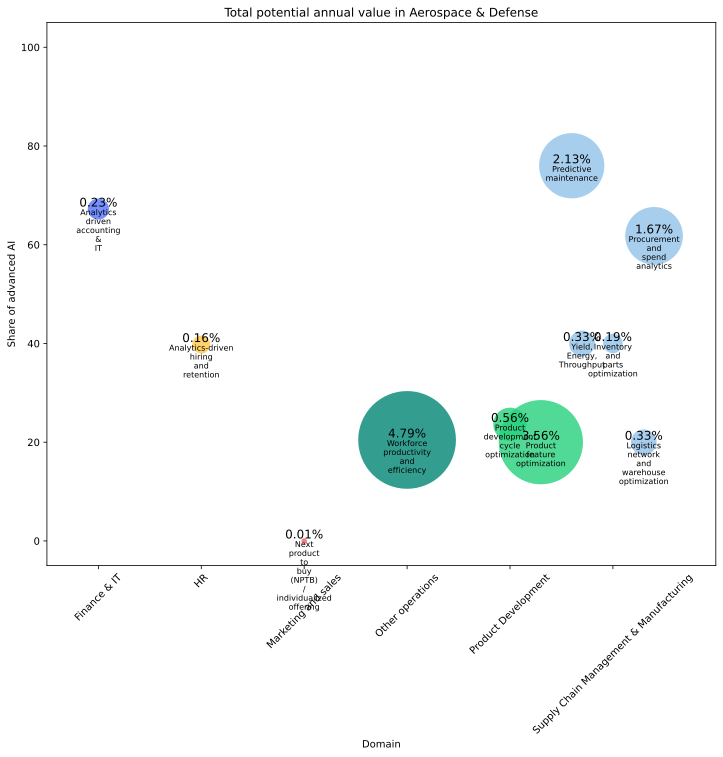

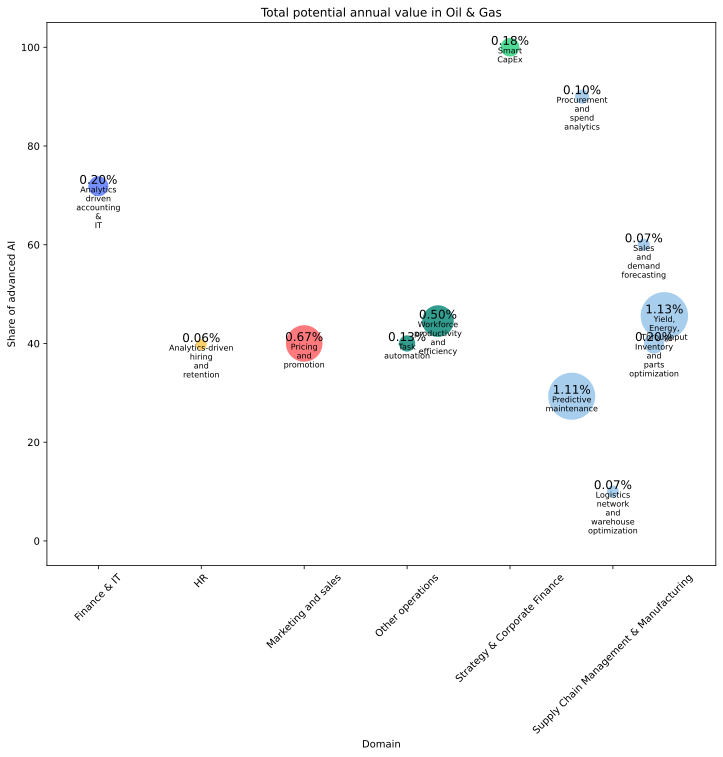

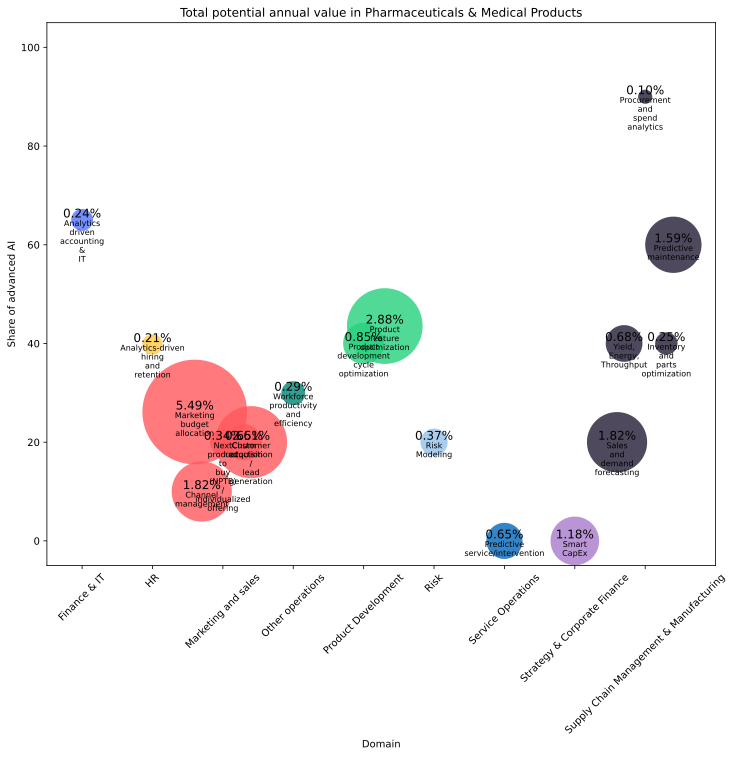

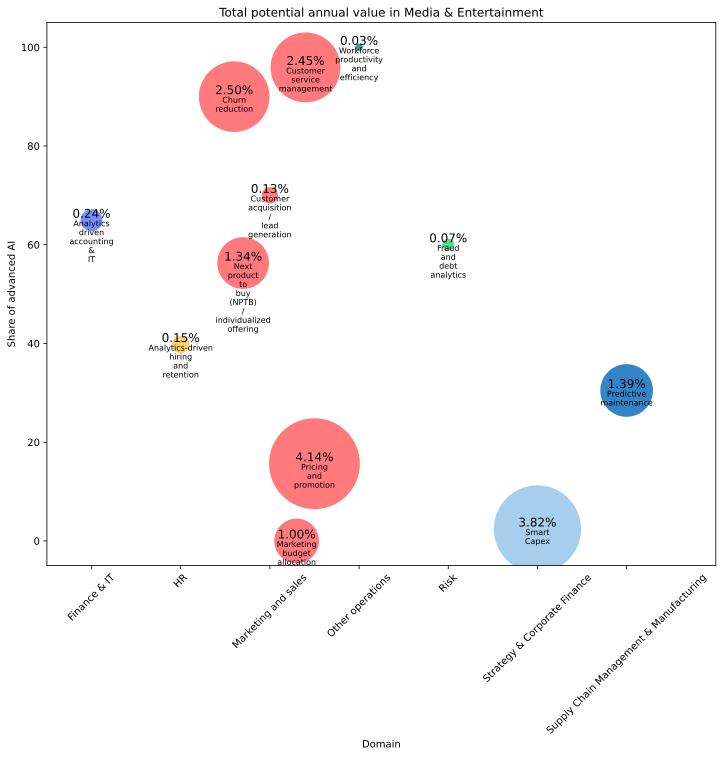

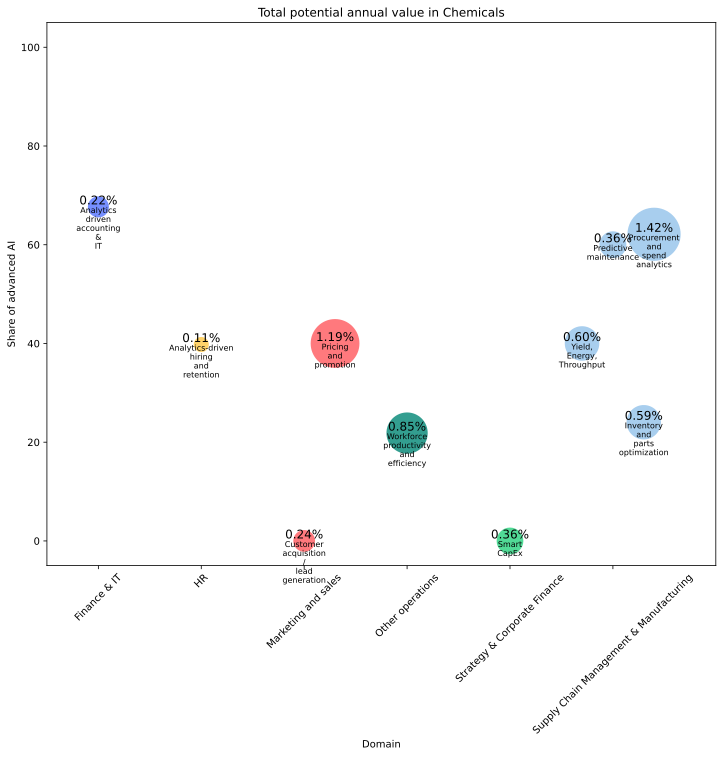

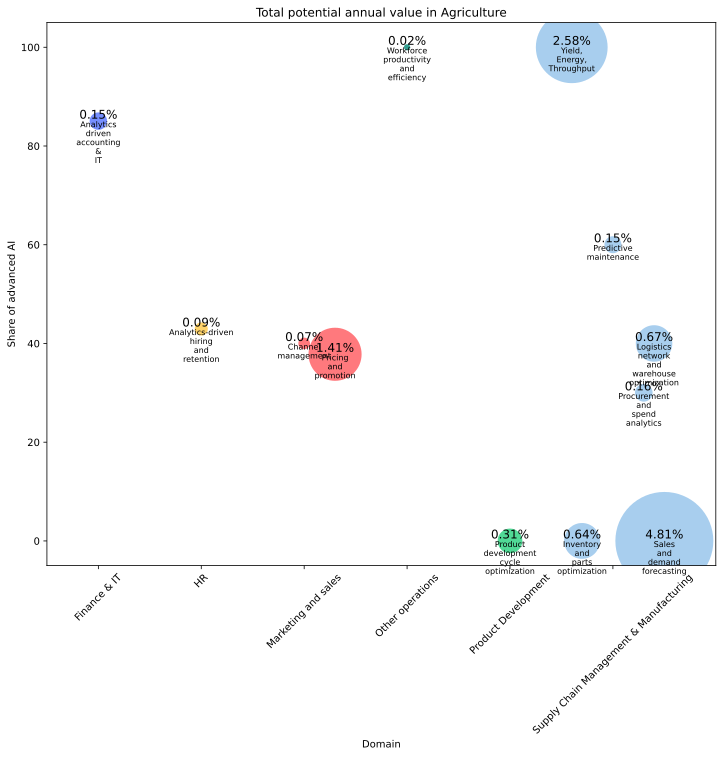

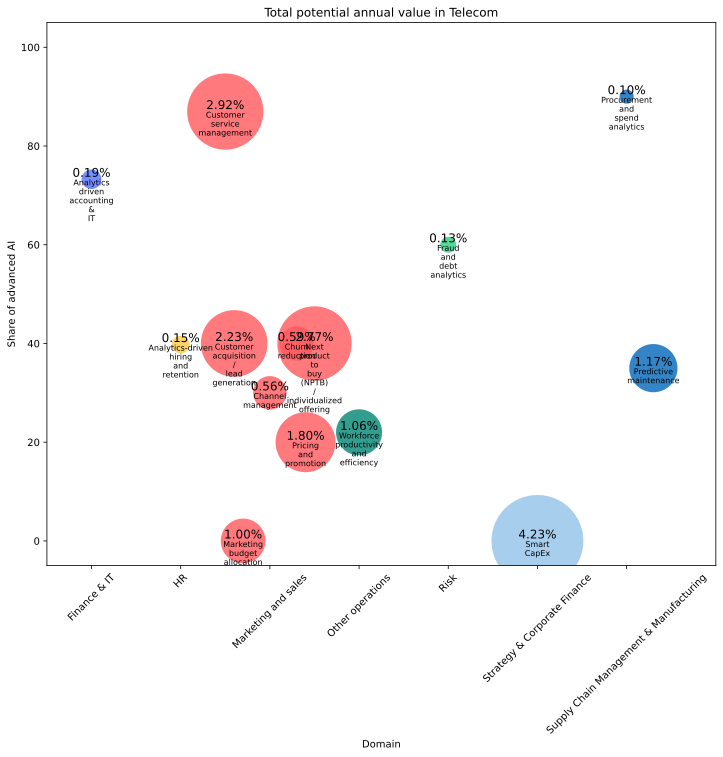

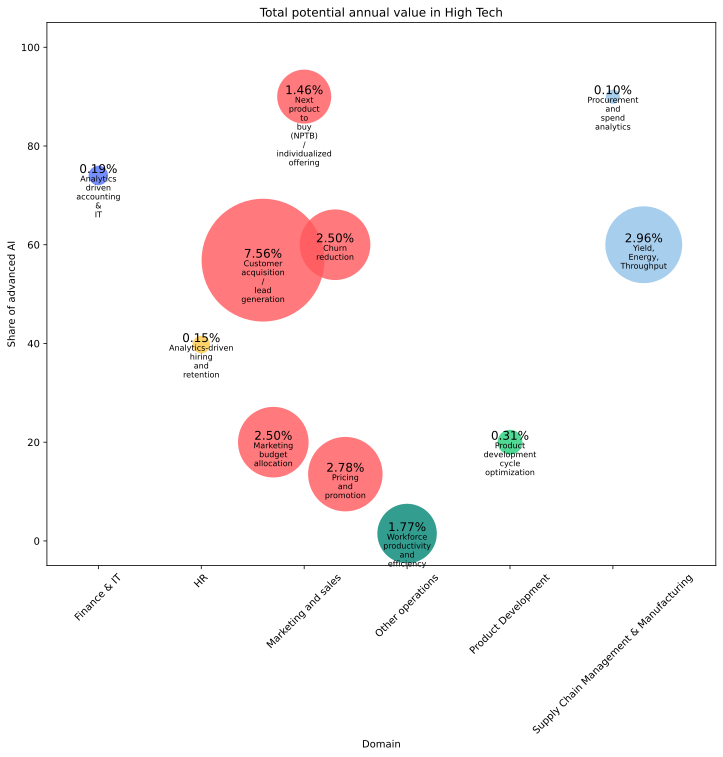

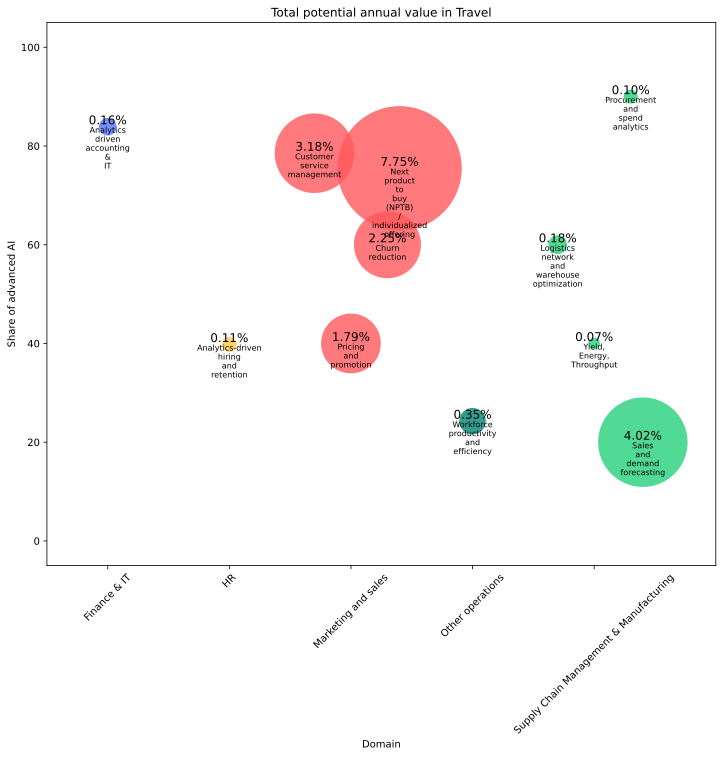

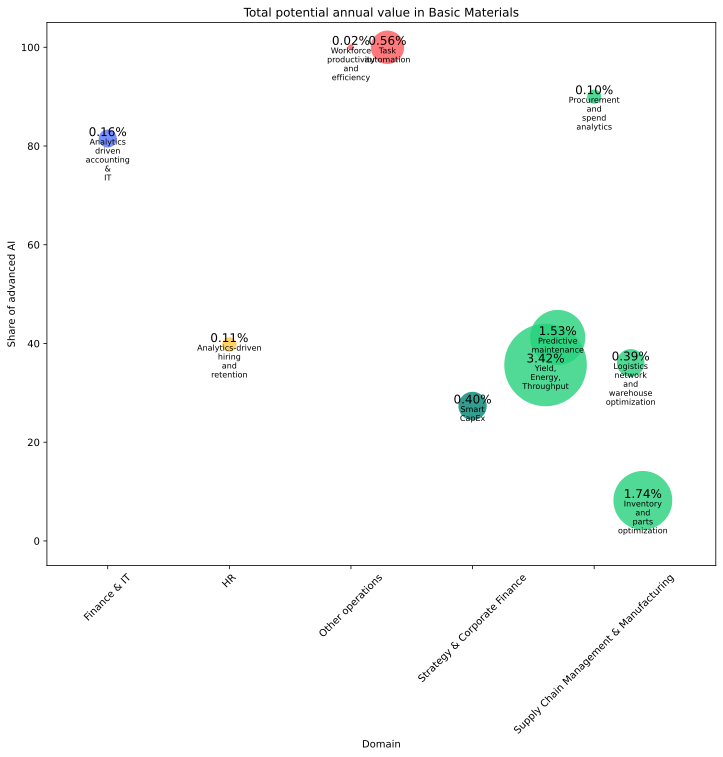

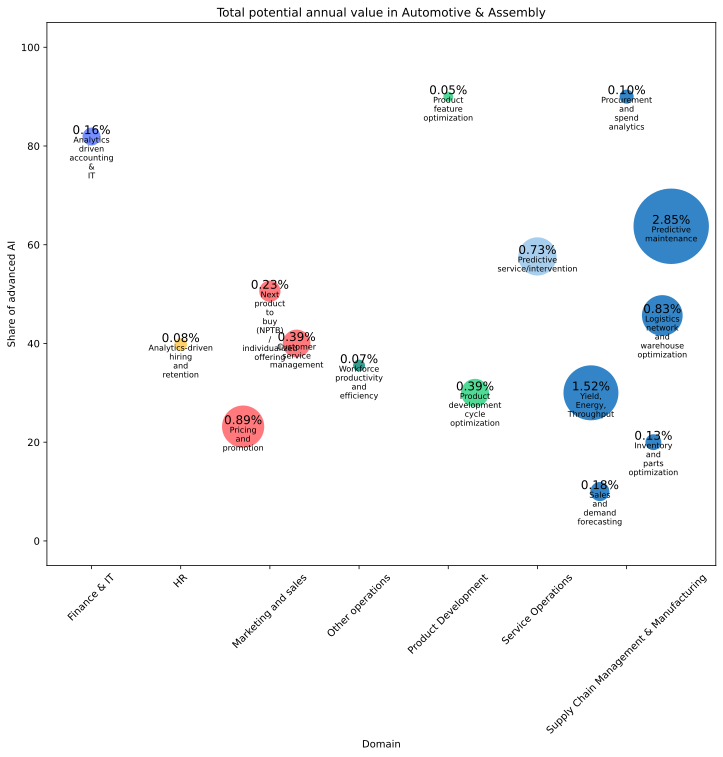

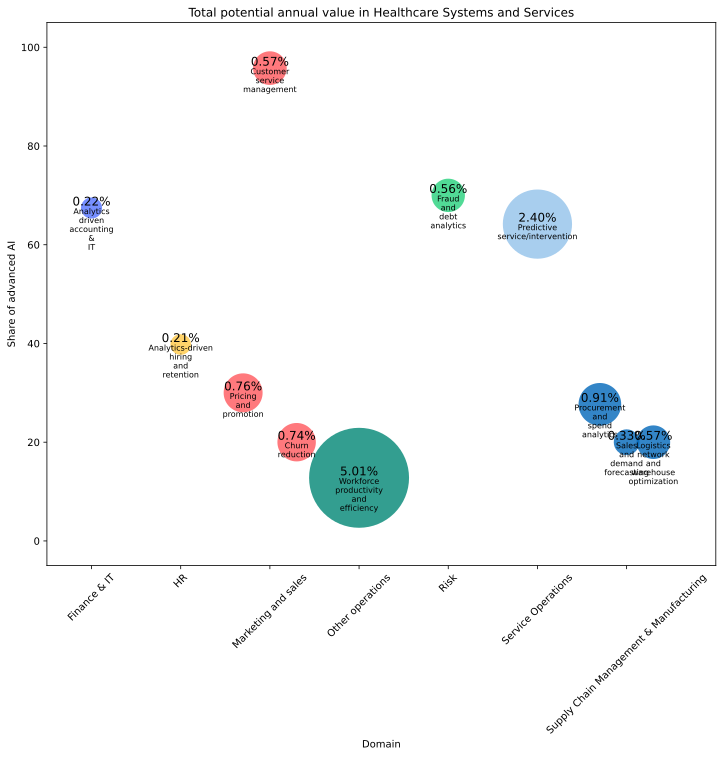

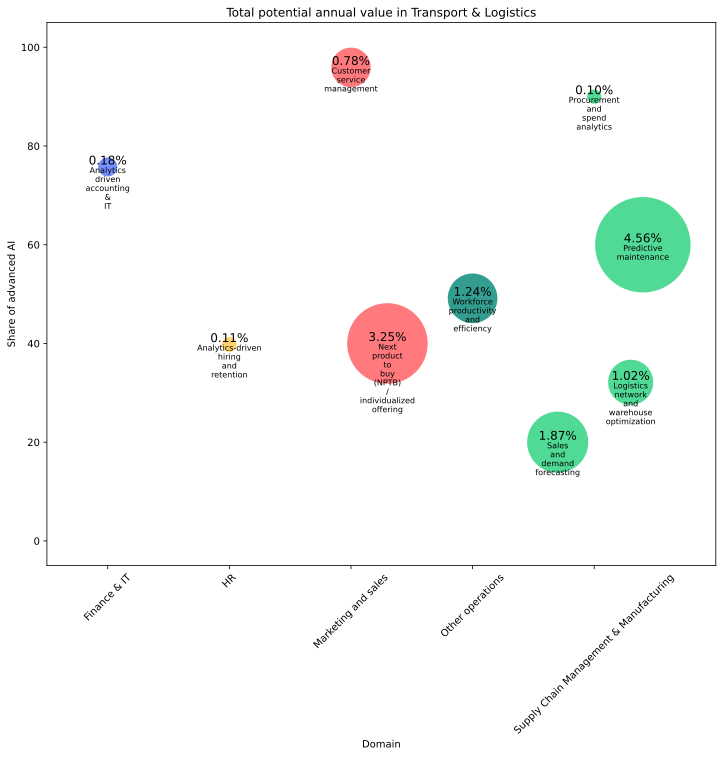

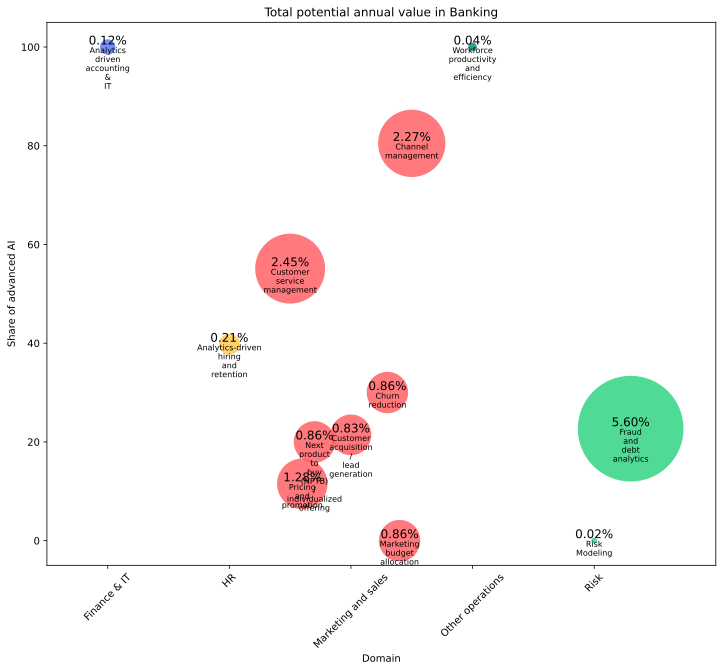

In [ ]:
focus_industry = None #"Travel"

for i,ind in enumerate(tree["children"]):
    current_domains = pd.json_normalize(ind["children"],record_path=["children"],record_prefix="domain.",meta=["name"],errors="ignore")
    
    if focus_industry:
        if ind["name"] == focus_industry:
            bubbleplot_industry(current_domains,ind["name"]) 
            break     
    else:
        bubbleplot_industry(current_domains,ind["name"])
    
#current_industry = pd.json_normalize(ind)
#current_functions = pd.json_normalize(ind["children"])        
#current_domains = pd.json_normalize(current_industry["children"],record_path=["children"],record_prefix="domain.",meta=["name"],errors="ignore")